In [1]:
import geopandas as gpd
import xarray as xr
import sys
sys.path.append('../')
from utilities.era5_down import cropped_nc, era5_down, sel_glacier
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
filename = '../data/mass_balance/DOI-WGMS-FoG-2021-05/WGMS-FoG-2021-05-EE-MASS-BALANCE.csv'
df1 = pd.read_csv(filename, delimiter=',', engine='python', index_col=['YEAR'],
encoding= 'unicode_escape')
print(df1.columns)
display(df1)

Index(['POLITICAL_UNIT', 'NAME', 'WGMS_ID', 'LOWER_BOUND', 'UPPER_BOUND',
       'AREA', 'WINTER_BALANCE', 'WINTER_BALANCE_UNC', 'SUMMER_BALANCE',
       'SUMMER_BALANCE_UNC', 'ANNUAL_BALANCE', 'ANNUAL_BALANCE_UNC',
       'REMARKS'],
      dtype='object')


,POLITICAL_UNIT,NAME,WGMS_ID,LOWER_BOUND,UPPER_BOUND,AREA,WINTER_BALANCE,WINTER_BALANCE_UNC,SUMMER_BALANCE,SUMMER_BALANCE_UNC,ANNUAL_BALANCE,ANNUAL_BALANCE_UNC,REMARKS
YEAR,,,,,,,,,,,,,
1972,AQ,ALBERICH,1062,9999,9999,1.36,0.0,NaN,10.0,NaN,20.0,NaN,NaN
1973,AQ,ALBERICH,1062,9999,9999,1.36,0.0,NaN,30.0,NaN,30.0,NaN,NaN
1974,AQ,ALBERICH,1062,9999,9999,1.36,-10.0,NaN,0.0,NaN,-20.0,NaN,NaN
1975,AQ,ALBERICH,1062,9999,9999,1.36,10.0,NaN,0.0,NaN,10.0,NaN,NaN
1966,AQ,ANVERS I ICE CAP,3954,9999,9999,NaN,NaN,NaN,NaN,NaN,44.0,NaN,Multi-annual observation (87 mm w.e.) evenly d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,US,YAWNING,75,9999,9999,NaN,NaN,NaN,NaN,NaN,-3360.0,100.0,NaN
2016,US,YAWNING,75,9999,9999,NaN,NaN,NaN,NaN,NaN,-960.0,100.0,NaN
2017,US,YAWNING,75,9999,9999,NaN,NaN,NaN,NaN,NaN,-640.0,200.0,NaN


In [3]:
sub1 = sel_glacier(df1, 'HURD')
sub2 = sel_glacier(df1, 'JOHNSONS')
sub3 = sel_glacier(df1, 'BELLINGSHAUSEN')
data_all = pd.concat([sub1, sub2, sub3])
data_all.dropna(inplace=True)
display(data_all)

,SMB,Glacier
Year,,
2002,530.0,HURD
2002,-670.0,HURD
2003,540.0,HURD
2003,-1060.0,HURD
2004,630.0,HURD
...,...,...
2010,-426.0,BELLINGSHAUSEN
2011,1023.0,BELLINGSHAUSEN
2011,-941.0,BELLINGSHAUSEN


In [4]:
HURD     = df1.loc[lambda df1: df1['NAME'] == 'HURD', 'ANNUAL_BALANCE'].rename('HURD') 
JOHNSONS = df1.loc[lambda df1: df1['NAME'] == 'JOHNSONS', 'ANNUAL_BALANCE'].rename('JOHNSONS')
BELLINGSHAUSEN = df1.loc[lambda df1: df1['NAME'] == 'BELLINGSHAUSEN', 'ANNUAL_BALANCE'].rename('BELLINGSHAUSEN')
A_MB = (pd.concat([HURD, JOHNSONS, BELLINGSHAUSEN], axis=1).loc[2002:2019])/1000
A_MB.to_csv('../data/mass_balance/SSI_SMB.csv', sep='\t')

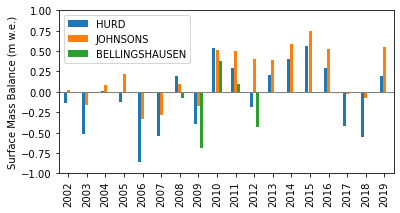

In [5]:
fig, (ax0) = plt.subplots(figsize=(6,3)) 
(A_MB).plot.bar(ax = ax0)
ax0.set_xlabel('')
ax0.set_ylabel(u'Surface Mass Balance (m w.e.)') 
ax0.set_ylim(-1.0, 1.0)
ax0.axhline(0, linewidth=1, color='grey', linestyle ='-')

In [6]:
ds   = xr.open_dataset('../data/static/SSI_static_200.nc')
df_g = gpd.read_file('../data/static/Shapefiles/SSI_all_fff.shp')

In [7]:
Hurd = df_g[df_g.Name == 'Hurd Glacier']
Johnsons = df_g[df_g.Name == 'Johnsons Glacier']
Belling = df_g[df_g.Name == 'Belling Glacier']
Belling.columns

Index(['RGIId', 'GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope',
       'Aspect', 'Lmax', 'Status', 'Connect', 'Form', 'TermType', 'Surging',
       'Linkages', 'Name', 'geometry'],
      dtype='object')

In [8]:
ds_belle = cropped_nc(ds, Johnsons)

In [9]:
files = sorted(glob.glob('../data/ERA_59_20_day/*.nc'))
len(files)

62

In [10]:
df_day = era5_down(files, ds_belle['lon'].mean().values,
                   ds_belle['lat'].mean().values,
                   ds_belle['HGT'].mean().values)


In [11]:
t2m = 't2m'
Snowfall = 'sf'

In [12]:
df_day['PDD'] = df_day[t2m].where(df_day[t2m] > 0, 0)
#df_day = df_day.groupby(['stake']).agg({t2m:np.mean, Snowfall:np.sum, 'PDD':np.sum})
df_day = df_day.resample('1M').agg({t2m:np.mean, Snowfall:np.sum, 'PDD':np.sum})
df_day

,t2m,sf,PDD
time,,,
1959-01-31,-0.983776,0.036343,0.000000
1959-02-28,-1.606607,0.055439,0.000000
1959-03-31,-1.923079,0.061861,0.100372
1959-04-30,-6.725998,0.030314,0.000000
1959-05-31,-5.909166,0.062854,0.000000
...,...,...,...
2020-08-31,-7.850718,0.091051,0.000000
2020-09-30,-5.925785,0.103812,0.000000
2020-10-31,-3.796816,0.090733,0.000000


In [13]:
df_day['Melt'] = df_day['PDD'] * -0.054
df_day

,t2m,sf,PDD,Melt
time,,,,
1959-01-31,-0.983776,0.036343,0.000000,-0.000000
1959-02-28,-1.606607,0.055439,0.000000,-0.000000
1959-03-31,-1.923079,0.061861,0.100372,-0.005420
1959-04-30,-6.725998,0.030314,0.000000,-0.000000
1959-05-31,-5.909166,0.062854,0.000000,-0.000000
...,...,...,...,...
2020-08-31,-7.850718,0.091051,0.000000,-0.000000
2020-09-30,-5.925785,0.103812,0.000000,-0.000000
2020-10-31,-3.796816,0.090733,0.000000,-0.000000


In [14]:
df_day['SMB'] = (df_day['sf'] + 0.5 * df_day['sf']) + df_day['Melt'] 
df_day

,t2m,sf,PDD,Melt,SMB
time,,,,,
1959-01-31,-0.983776,0.036343,0.000000,-0.000000,0.054514
1959-02-28,-1.606607,0.055439,0.000000,-0.000000,0.083158
1959-03-31,-1.923079,0.061861,0.100372,-0.005420,0.087372
1959-04-30,-6.725998,0.030314,0.000000,-0.000000,0.045471
1959-05-31,-5.909166,0.062854,0.000000,-0.000000,0.094280
...,...,...,...,...,...
2020-08-31,-7.850718,0.091051,0.000000,-0.000000,0.136577
2020-09-30,-5.925785,0.103812,0.000000,-0.000000,0.155719
2020-10-31,-3.796816,0.090733,0.000000,-0.000000,0.136100


In [15]:
df_day.describe()

,t2m,sf,PDD,Melt,SMB
count,744.000000,744.000000,744.000000,744.000000,744.000000
mean,-3.768171,0.057115,1.333581,-0.072013,0.013659
std,2.856384,0.025725,3.196321,0.172601,0.191577
min,-16.159903,0.000950,0.000000,-1.483898,-1.459740
25%,-5.533457,0.038360,0.000000,-0.050665,0.015421
50%,-3.252302,0.055671,0.000000,-0.000000,0.076345
75%,-1.354434,0.073982,0.938240,0.000000,0.106630
max,0.954574,0.142446,27.479584,-0.000000,0.213670


In [16]:
df_day['Year'] = df_day.index.year
Year = df_day.drop_duplicates(subset=['Year'])['Year'].values
Year

array([1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [17]:
annual_smb = []
for i in range(len(Year)-1):
    annual_smb.append(df_day.loc[str(Year[i])+'0401':str(Year[i+1])+'0331']['SMB'].sum())

In [18]:
annual_smb

df_data = pd.DataFrame(annual_smb, columns={'SIM'}, index = Year[1:])
df_data


,SIM
1960,0.482579
1961,0.487501
1962,-0.082735
1963,0.400422
1964,0.724097
...,...
2016,0.559184
2017,-1.442126
2018,-0.713282
2019,0.678540


In [19]:
A_MB.columns

Index(['HURD', 'JOHNSONS', 'BELLINGSHAUSEN'], dtype='object')

In [20]:
df_all = pd.merge(df_data, A_MB['JOHNSONS'], how='left', left_index=True, right_index=True)
df_all

,SIM,JOHNSONS
1960,0.482579,NaN
1961,0.487501,NaN
1962,-0.082735,NaN
1963,0.400422,NaN
1964,0.724097,NaN
...,...,...
2016,0.559184,0.53
2017,-1.442126,-0.03
2018,-0.713282,-0.08
2019,0.678540,0.55


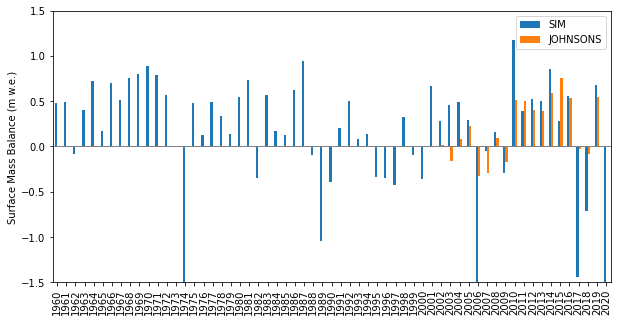

In [21]:
fig, (ax0) = plt.subplots(figsize=(10,5)) 
(df_all).plot.bar(ax = ax0)
ax0.set_xlabel('')
ax0.set_ylabel(u'Surface Mass Balance (m w.e.)') 
ax0.set_ylim(-1.5, 1.5)
ax0.axhline(0, linewidth=1, color='grey', linestyle ='-')